In [19]:
%matplotlib widget
from typing import Callable, Tuple
import functools

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

# Metropolis-Hastings Markov Chain Monte Carlo
Alex Gorodetsky, October 2020, March 2024

In this notebook we provide code for the MH-MCMC algorithm and analyze properties of MCMC in general. 

MCMC algorithms aim to sample from some target distribution $P_X$ --- in the case of continuous random variables we will use the density $f_X$. These algorithms are used when it is impossible to generate independent samples by other means (e.g., inverse CDF, Gaussians, etc.). They are also used when one can evaluate $f_X$ only up to a normalizing constant -- as in the case of Bayesian inference.

The Metropolis-Hastings variants of MCMC algorithms rely on an accept-reject probability. Specifically, given a proposal PDF (could be un-normalized) $q$, the current sample $x^{(k)}$ and a proposed sample $y$, the acceptance probability is
\begin{equation}
a(x^{(k)}, y) = \min \left\{ \frac{f_X(y)}{f_X(x^{(k)})} \frac{q(x^{(k)} \mid y)}{q(y \mid x^{(k)})}, \  1 \right\}
\end{equation}
where we see that the normalizing constant doesnt matter because it would be cancelled by the ratios. It is often simpler to write these in terms of log-pdfs so that we have $a(x^{(k)}, y) = \exp(\tilde{a}(x^{(k)}, y))$ where 

$$
\tilde{a}(x^{(k)}, y) = \min \left\{ \log f_X(y) - \log f_X(x^{(k)}) + \log q(x^{(k)} \mid y) - \log q(y \mid x^{(k)}), \  0 \right\}
$$

In [3]:
Log_pdf_t = Callable[[np.ndarray], float] # log pdf type
Log_pdfc_t = Callable[[np.ndarray, np.ndarray], float] # conditional pdf types
Sampler = Callable[[np.ndarray], np.ndarray] # conditional sampler type

def mh_acceptance_prob(current_target_logpdf: float,
                       proposed_target_logpdf: float,
                       current_sample: np.ndarray,
                       proposed_sample: np.ndarray,
                       proposal_func: Log_pdfc_t) -> float:
    """Compute the metropolis-hastings accept-reject probability.

    Args:
        current_target_logpdf: float, logpdf at the current sample in the chain f_X(x^{(k)})
        proposed_target_logpdf: float, logpdf at the proposed sample in the chain
        current_sample: (d, ), current sample
        proposed_sample: (d, ), proposed sample
        proposal_func: f(x, y) callable that gives the log probability of y given x

    Returns:
        acceptance probability
    """

    prop_reverse = proposal_func(proposed_sample, current_sample)
    prop_forward = proposal_func(current_sample, proposed_sample)
    check = proposed_target_logpdf - current_target_logpdf + prop_reverse - prop_forward # check this
    if check < 0:
        return np.exp(check)
    return 1.0

Now we have implement the Metropolis Hastings Markov Chain Monte Carlo algorithm
1. Propose sample y
2. Compute acceptance probability
3. Accept or reject sample y
4. Repeat

In [4]:
def mhmcmc(starting_sample: np.ndarray,
           num_samples: int,
           target_logpdf: Log_pdf_t,
           proposal_logpdf: Log_pdfc_t,
           proposal_sampler: Sampler) -> Tuple[np.ndarray, float]:
    """Metropolis-Hastings MCMC.

    Args:
        starting_sample: (d, ) the initial sample
        num_sample: positive integer, the number of total samples
        target_logpdf: function(x) -> logpdf of the target distribution
        proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
        proposal_sampler: function (x) -> y, generate a sample if you are currently at x

    Returns:
        Samples: (num_samples, d) array of samples
        accept_ratio: ratio of proposed samples that were accepted
    """

    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])

    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :])
        proposed_target_logpdf = target_logpdf(proposed_sample)

        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logpdf)

        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # reject
                samples[ii, :] = samples[ii-1, :]

    return samples, num_accept / float(num_samples-1)

## Random Walk Proposal

We first consider a random walk proposal proposes the next step according to a random walk

\begin{equation}
Y = x^{(k)} + \xi,
\end{equation}

where $\xi \sim \mathcal{N}(0, \Gamma)$ for a Gaussian random walk with some covariance $\Gamma$. In other words, the proposal is 

\begin{equation}
q(y \mid x) = \frac{1}{2\pi^{d/2}|\Gamma|^{1/2}} \exp\left( -\frac{1}{2} \lVert y - x^{(k)} \rVert_{\Gamma}^2 \right)
\end{equation}

There is some theory (derived for a Gaussian target distribution) that suggests an "optimal" covariance

\begin{equation}
\Gamma = \left(\frac{2.38}{\sqrt{d}}\right)^2 \Sigma,
\end{equation}

where $\Sigma$ is the true covariance of the target distribution. 

Another rule of thumb is that a good proposal distribution will typically result in 20-30% of the proposed samples being accepted. 

Finally, if the proposal is only function of the distance between $y$ and $x$ $q(y \mid x) = q(|y - x|)$, such as the Gaussian random walk proposal given above, then the acceptance probability simplifies to 

\begin{equation}
a(x, y) = \min\left\{ 1, \frac{f_X(y)}{f_X(x)} \right\}
\end{equation}


In [5]:
def proposal_rw_sampler(x: np.ndarray, std: float = 1.0) -> np.ndarray:
    """Sample from a random walk proposal with identity covariance."""
    y = std * np.random.randn(x.shape[0]) + x
    return y

def proposal_rw_logpdf(x: np.ndarray, y: np.ndarray, std: float = 1.0) -> np.ndarray:
    """Probability of moving from x to y (in this case it is symmetric)."""
    delta = x - y
    logpdf = -0.5 * np.dot(delta, delta) / std / std
    return logpdf

### Examples

Lets look at a couple of examples: sampling from a Gaussian and from a "Banana"

#### A Gaussian distribution

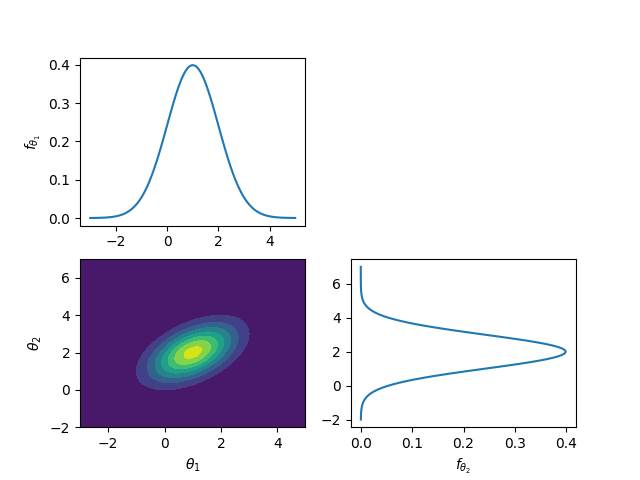

In [6]:
gauss_mean = np.array([1, 2])
gauss_cov = build_cov_mat(1.0, 1.0, 0.5) # std, std, correlation
target_logpdf_gauss = lambda x: lognormpdf(x[:, np.newaxis], gauss_mean, gauss_cov)
plt.close(1)
fig, axs = plot_bivariate_gauss(1, np.linspace(-3, 5, 100), np.linspace(-2,7,100), gauss_mean, gauss_cov)
plt.show()

In [7]:
num_samples = 10000
dim = 2
#initial_sample = np.random.randn(2) # random location
initial_sample = np.array([10, 10])

prop_sampler = lambda x: proposal_rw_sampler(x, std=2)
prop_logpdf = lambda x, y: proposal_rw_logpdf(x, y, std=2)
samples, ar = mhmcmc(initial_sample, num_samples, target_logpdf_gauss, prop_logpdf, prop_sampler)

print("Accepted Samples Ratio:", ar)

Accepted Samples Ratio: 0.2514251425142514


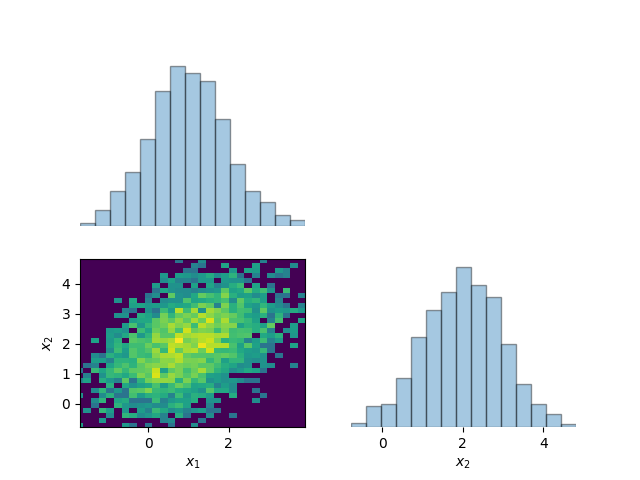

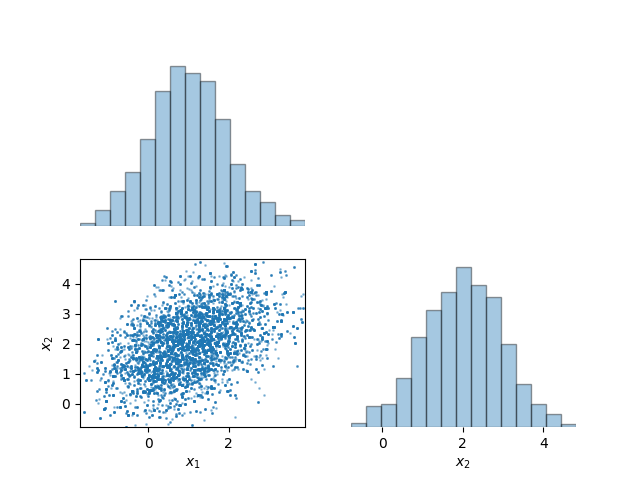

In [9]:
# plot samples from posterior
plt.close(2)
fig, axs, gs = scatter_matrix(2, [samples], labels=[r'$x_1$', r'$x_2$'],
                              hist_plot=False, gamma=0.4)
plt.close(3)
fig, axs, gs = scatter_matrix(3, [samples], labels=[r'$x_1$', r'$x_2$'],
                              hist_plot=True, gamma=0.2,
                              nbins=70)
# fig.set_size_inches(7,7)
plt.show()

The first thing we look at to assess whether this is "good" is a plot of the trace of the samples. A trace of the samples is looking at the Markov Process, remember that if the samples were independent it would look like pure white noise. We want independent samples so we really want it to look like pure white noise. This plot is really the closet thing to fool proof to see if things are proceeding well. (Though it is not the end of the story!)

Text(0.5, 0, 'Sample Number')

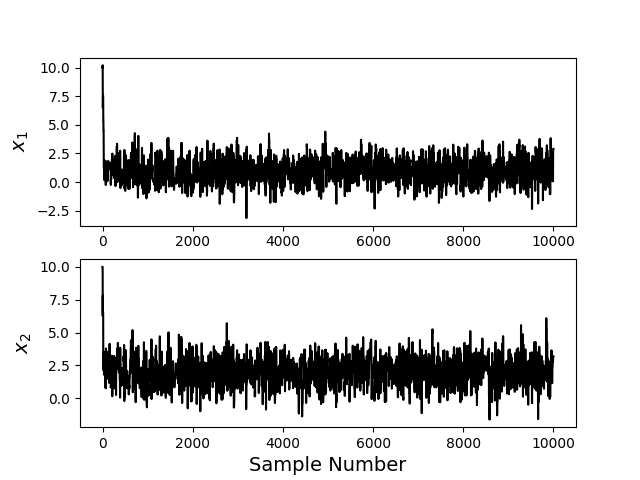

In [11]:
plt.close(4)
fig, axs = plt.subplots(2, 1, num=4)
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

This sample trace should look like white noise -- intuitively this means that each sample is very close to independent because they are "not correlated"

These samples obviously have some correlation amongst them. Recall that Monte Carlo samples are independent. As a result, it may be useful to determine how much correlation exists amongst these samples and to tune your proposal so that there is as little correlation as possible. The correlation of a time-series with itself is called the autocorrelation. 

Intuitvely, we are looking for the correlation between the function values some distance $k$ apart $Cov(X_i, X_{i+k})$. This correlation can then be estimated from all pairs of samples that are $k$ apart. For more details see Lecture notes 16.1.3. 

In [12]:
def autocorrelation(samples: np.ndarray, maxlag: int=100, step: int=1):
    """Compute the correlation of a set of samples.

    Args:
        samples: (N, d)
        maxlag: maximum distance to compute the correlation for
        step: step between distances from 0 to maxlag for which to compute teh correlations
    """

    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]

    # Compute the mean
    mean = np.mean(samples, axis=0)

    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2

    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

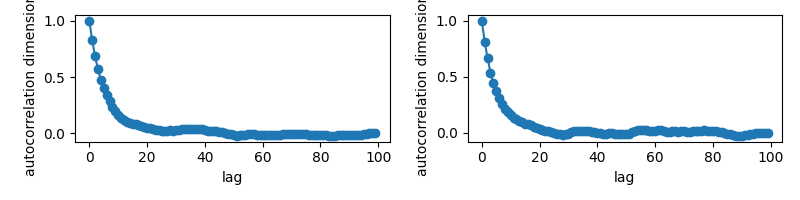

In [16]:
maxlag=100
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag, step=step)
plt.close(5)
fig, axs = plt.subplots(1, 2, figsize=(8, 2), num=5)
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.tight_layout()
plt.show()

We want this correlation to decay rapidly because when it gets to zero, it means that there is essentially no correlation between samples further than that intercept apart

#### "Banana Function"

\begin{equation}
\log f_X(x,y) = -(1 - x)^2 - 100 (y - x^2)^2
\end{equation}

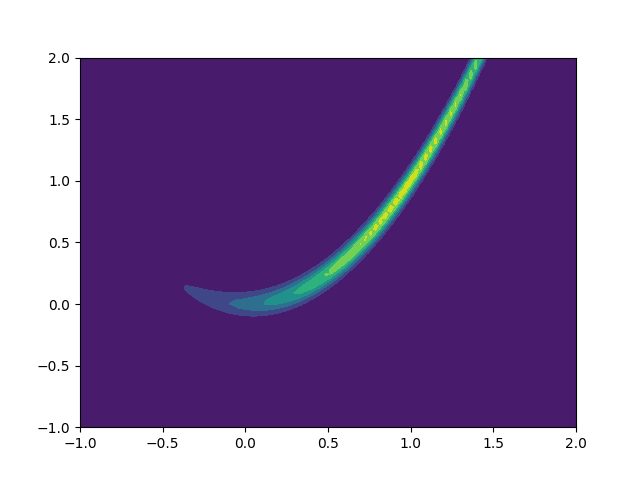

In [24]:
def banana_logpdf(x):
    a = 1.0
    b = 100.0
    logpdf = -(a-x[0])**2 - b * (x[1] - x[0]**2)**2
    #logpdf = np.exp(-0.5 * (x[0])**2 + x[1]**2) - np.exp(-0.5 / 1.0 * (x[0]**2 + x[1]**2))
    #logpdf = np.log(logpdf)
    #logpdf = (np.sin(10*x[0]*x[1]) + x[1]**2)*4
    return logpdf
    # return logpdf

def plot_banana(fignum):
    plt.figure(fignum)
    xgrid = np.linspace(-1, 2, 100)
    ygrid = np.linspace(-1, 2, 100)
    XX, YY = np.meshgrid(xgrid, ygrid)
    plt.contourf(XX, YY, eval_func_on_grid(compose(np.exp, banana_logpdf), xgrid, ygrid).T)

plt.close(6)
plot_banana(6)

In [26]:
num_samples = 100000
dim = 2
initial_sample = np.random.randn(2) # random location
target_logpdf = banana_logpdf

p_sampler = lambda x: proposal_rw_sampler(x, std=3e-1) #3e-1
p_eval = lambda x, y: proposal_rw_logpdf(x, y, std=3e-1)
samples, ar = mhmcmc(initial_sample, num_samples, target_logpdf, p_eval, p_sampler)

print("Accepted Samples Ratio:", ar)

Accepted Samples Ratio: 0.14611146111461115


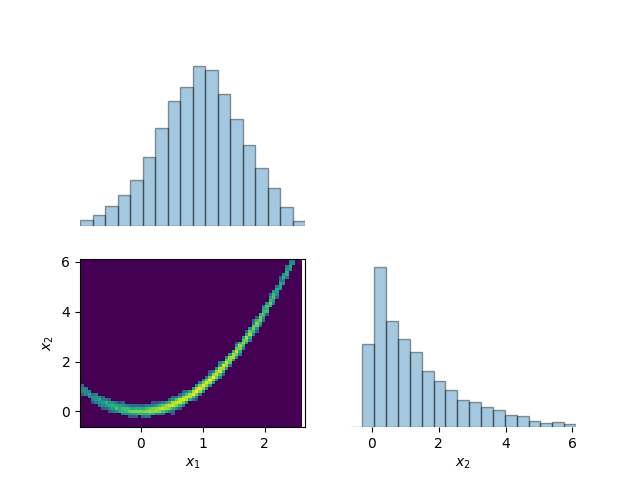

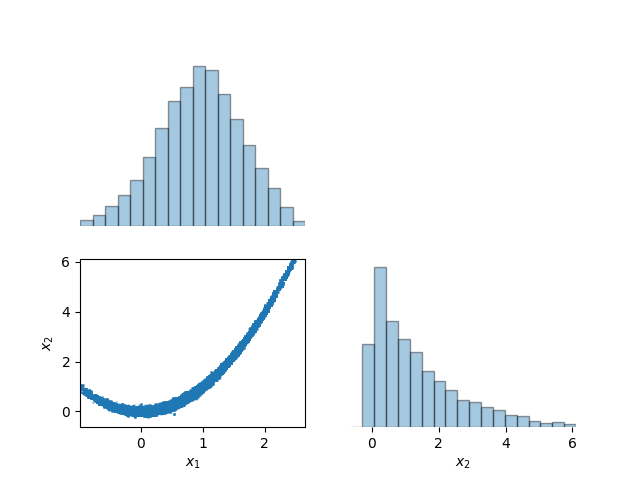

In [27]:
# plot samples from posterior
plt.close(7)
fig, axs, gs = scatter_matrix(7, [samples], labels=[r'$x_1$', r'$x_2$'], hist_plot=False, gamma=0.4)
plt.close(8)
fig, axs, gs = scatter_matrix(8, [samples], labels=[r'$x_1$', r'$x_2$'], hist_plot=True, gamma=0.2,
                                 nbins=70)
#fig.set_size_inches(7,7)
plt.show()

Text(0.5, 0, 'Sample Number')

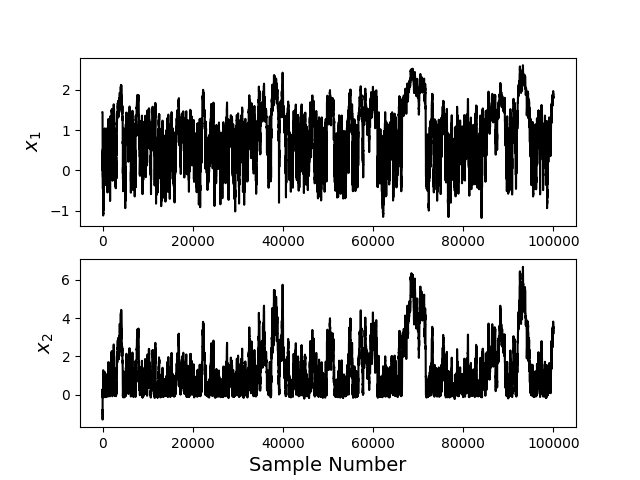

In [29]:
plt.close(9)
fig, axs = plt.subplots(2, 1, num=9)
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)

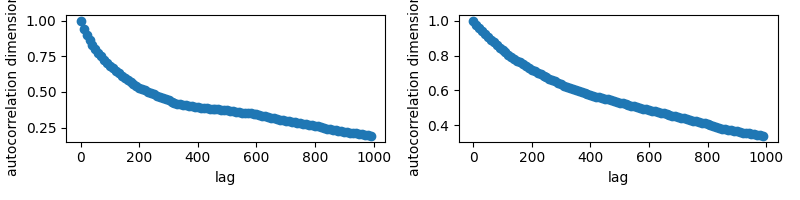

In [31]:
maxlag=1000
step=10
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
plt.close(10)
fig, axs = plt.subplots(1, 2, figsize=(8, 2), num=10)
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.tight_layout()
plt.show()

## Independent Proposal

An independent proposal proposes samples independently for each step of the Markov chain. Here one has to be careful that every state with non-zero probability can actually be proposed. We will only consider cases where this is the case. An independent proposal takes the form

\begin{equation}
q(y \mid x) = q(y),
\end{equation}
which follows from the definition of independence.

The acceptance probability can then be simplified as 

\begin{equation}
a(x,y) = \min \left \{\frac{f_X(y)}{f_X(x)} \frac{q(x)}{q(y)},  1 \right \}
\end{equation}


In [33]:
def proposal_indep_sampler(x, mean, sqrtcov):
    """Independent proposal,  X doesnt matter!

    Only requires mean and squart root of the covariance
    """
    y = mean + np.dot(sqrtcov, np.random.randn(mean.shape[0]))
    return y

def proposal_indep_logpdf(x, y, mean, cov):
    """Probability of moving from x to y (X doesnt matter!)"""
    delta = y - mean
    logpdf = -0.5 * np.dot(delta, np.linalg.solve(cov, delta))
    return logpdf

#### Gaussian example

In [34]:
num_samples = 10000
dim = 2
initial_sample = np.random.randn(2) # random location
#inital_sample = np.array([1,2])

prop_cov = np.diag([1e1, 1e1])
sqrt_cov = np.sqrt(prop_cov) # because diagonal, otherwise do cholesky
#mean_cov = np.zeros((2))
mean_cov = np.array([1, 2]) #really need a good starting point!

p_ind = lambda x: proposal_indep_sampler(x, mean_cov, sqrt_cov)
p_lpdf = lambda x, y: proposal_indep_logpdf(x, y, mean_cov, prop_cov)
samples, ar = mhmcmc(initial_sample, num_samples, target_logpdf_gauss, p_lpdf, p_ind)

print("Accepted Samples Ratio:", ar)

Accepted Samples Ratio: 0.1549154915491549


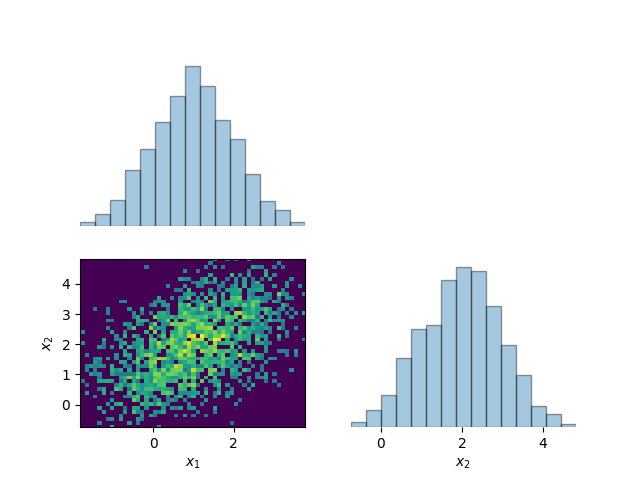

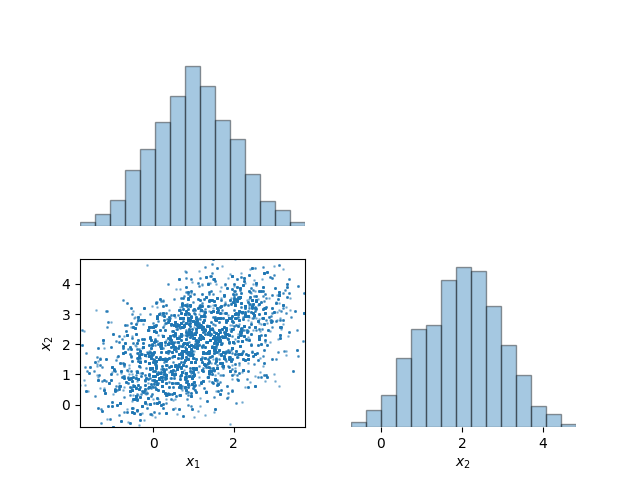

In [35]:
# plot samples from posterior
plt.close(11)
fig, axs, gs = scatter_matrix(11, [samples], labels=[r'$x_1$', r'$x_2$'],
                              hist_plot=False, gamma=0.4)
plt.close(12)
fig, axs, gs = scatter_matrix(12, [samples], labels=[r'$x_1$', r'$x_2$'],
                              hist_plot=True, gamma=0.2, nbins=70)
plt.show()

Text(0.5, 0, 'Sample Number')

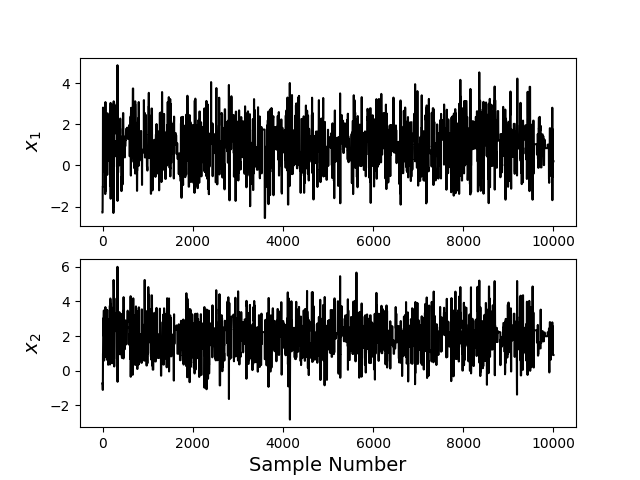

In [36]:
plt.close(13)
fig, axs = plt.subplots(2, 1, num=13)
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)

## Some tips

Mainly for the random walk proposal, as these are far more useful and used.

1. Discard some initial fraction of samples --- this is called "burn-in"
2. Start with a good guess for both the initial sample and the proposal covariance. For instance a Laplace approximation.